# Assignment 1: use ANNs to discover the summation function (using classifier)

In [60]:
import pandas as pd
import numpy as np
import scipy as scp
import tensorflow as tf
import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.models import load_model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import random
import sklearn as sk
from sklearn.model_selection import train_test_split
%matplotlib inline

## construct the different datasets

In [15]:
def construct_my_dataset(size=10000, seed = 54321, remove_number=None):
    random.seed(seed)
    x1 = np.array([random.randint(0,100) for i in range(size)])
    x2 = np.array([random.randint(0,100) for i in range(size)])
    y = x1 + x2
    df = pd.DataFrame({'x1':x1,'x2':x2,'y':y})
    if remove_number:
        df = df[((df.x1!=remove_number) & (df.x2!=remove_number))].copy()
    return df


In [16]:
df_100k = construct_my_dataset(size=int(1e5), seed=12345)
df_1m = construct_my_dataset(size=int(1e6), seed=54123)
df_10m = construct_my_dataset(size=int(1e7), seed=54123)

In [17]:
print (df_100k.shape)
print (df_1m.shape)
print (df_10m.shape)

(100000, 3)
(1000000, 3)
(10000000, 3)


## Train the NN classifier

In [56]:
def run_nn_classifier(dataset, test_size=0.2\
                      , lr = 0.1, training_epochs = 10, batch_size=100 \
                      , hidden_layers = [4,4]\
                      , lossf = 'categorical_crossentropy', optimizer = 'SGD'\
                      , metrics_to_report = ['accuracy']\
                      , verbose =1
                      , normalize = True
                     , remove_num_from_training = None):
    X_train, X_test, y_train, y_test = train_test_split(dataset[['x1','x2']], dataset['y'], test_size =test_size)
    
    # Remove certain number from the training set to make it harder
    if remove_num_from_training:
        ids_to_del = X_train[((X_train.x1== remove_num_from_training) + (X_train.x2==remove_num_from_training))].index.tolist()
        print ('Number of records deleted from training set: %d' % len(ids_to_del))
        y_train.drop(ids_to_del, inplace=True, axis=0)
        X_train.drop(ids_to_del, inplace=True, axis=0)
    
    # convert class vectors to binary One Hot Encoded
    n_classes = dataset['y'].unique().shape[0]
    y_train = keras.utils.to_categorical(y_train, n_classes)
    y_test = keras.utils.to_categorical(y_test, n_classes)
    
    # Normalize the data
    X_train = np.array(X_train)/100
    X_test = np.array(X_test)/100
    # Network Parameters
    n_input = 2
    
    # Build layers of NN network
    Inp = Input(shape=(n_input,))
    x = Inp
    for i, hidden_layer_size in enumerate(hidden_layers):
        x = Dense(hidden_layer_size, activation='relu', name = "Dense_{0}".format(i))(x)
    #output layer specified separately    
    output = Dense(n_classes, activation='softmax', name = "Outputlayer")(x)
    model = Model(Inp, output)
    if verbose:
        print(model.summary())
    
    model.compile(loss=lossf,
              optimizer=optimizer,
              metrics=metrics_to_report)
    
    K.set_value(model.optimizer.lr, lr)
    
    history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=verbose, # This is for what we want it to display out as it trains 
                    validation_data=(X_test, y_test))
    
    return history, model

def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

def get_top_n_predict(mymodel, test_data, top_n = 10):
    print ('*'*20)
    print ('%s => sum = %d' % (str(test_data*100), test_data.sum()*100))
    print ('*'*20)
    res = mymodel.predict(test_data)[0]
    zips = zip(range(0,201), res)
    for i in sorted(zips, key=lambda x: x[1], reverse=True)[:top_n]:
        print(i)
    print('*'*20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
Dense_0 (Dense)              (None, 100)               300       
_________________________________________________________________
Dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
Dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
Outputlayer (Dense)          (None, 201)               4221      
Total params: 10,591
Trainable params: 10,591
Non-trainable params: 0
_________________________________________________________________
None
Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 4s - loss: 5.1883 - acc: 

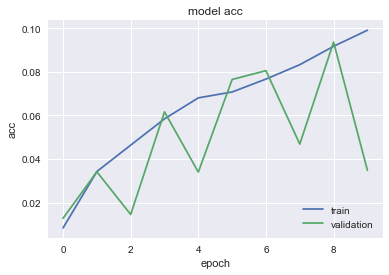

In [62]:
history, model_100k = run_nn_classifier(df_100k, hidden_layers=[100,50,20])
plot_train(history)

In [63]:
model_100k.save('model_100k.h5')
if False:
    model_100k = load_model('model_100k.h5')

get_top_n_predict(model_100k, np.array([[50,5]])/100, 5)
get_top_n_predict(model_100k, np.array(X_test)[0:1]/100, 5)
get_top_n_predict(model_100k, np.array(X_test)[10:11]/100, 5)

********************
[[ 50.   5.]] => sum = 55
********************
(50, 0.18091643)
(48, 0.14315107)
(51, 0.075377136)
(53, 0.067915514)
(49, 0.067672551)
********************
********************
[[ 21.  89.]] => sum = 110
********************
(103, 0.20316879)
(107, 0.14243028)
(108, 0.13023776)
(106, 0.11796224)
(105, 0.087842189)
********************
********************
[[ 99.   0.]] => sum = 99
********************
(98, 0.18384625)
(97, 0.17027988)
(93, 0.12014645)
(99, 0.11389501)
(95, 0.083519429)
********************


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
Dense_0 (Dense)              (None, 500)               1500      
_________________________________________________________________
Dense_1 (Dense)              (None, 400)               200400    
_________________________________________________________________
Dense_2 (Dense)              (None, 300)               120300    
_________________________________________________________________
Outputlayer (Dense)          (None, 201)               60501     
Total params: 382,701
Trainable params: 382,701
Non-trainable params: 0
_________________________________________________________________
None
Train on 800000 samples, validate on 200000 samples
Epoch 1/2
800000/800000 [==============================] - 110s - loss: 3.3306 

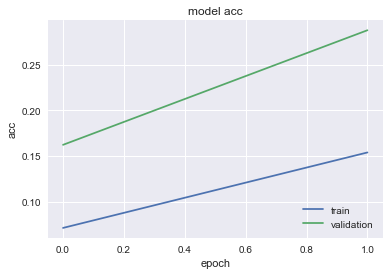

In [64]:
history, model_1m = run_nn_classifier(df_1m, hidden_layers=[500,400,300], training_epochs=2)
plot_train(history)

In [68]:
model_1m.save('model_1m.h5')
if False:
    model_1m = load_model('model_1m.h5')

get_top_n_predict(model_1m, np.array([[50,5]])/100, 5)
get_top_n_predict(model_1m, np.array(X_test)[0:1]/100, 5)
get_top_n_predict(model_1m, np.array(X_test)[10:11]/100, 5)

********************
[[ 50.   5.]] => sum = 55
********************
(57, 0.27721187)
(60, 0.26874447)
(58, 0.15579568)
(59, 0.10102533)
(56, 0.070711583)
********************
********************
[[ 21.  89.]] => sum = 110
********************
(110, 0.29805246)
(112, 0.25150287)
(108, 0.1095579)
(109, 0.10870925)
(111, 0.10202827)
********************
********************
[[ 99.   0.]] => sum = 99
********************
(99, 0.26915908)
(98, 0.22927479)
(97, 0.20818409)
(100, 0.10339667)
(101, 0.093651041)
********************


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
Dense_0 (Dense)              (None, 542)               1626      
_________________________________________________________________
Dense_1 (Dense)              (None, 400)               217200    
_________________________________________________________________
Dense_2 (Dense)              (None, 300)               120300    
_________________________________________________________________
Outputlayer (Dense)          (None, 201)               60501     
Total params: 399,627
Trainable params: 399,627
Non-trainable params: 0
_________________________________________________________________
None
Train on 784207 samples, validate on 196052 samples
Epoch 1/50
784207/784207 [==============================] - 105s - loss: 3.3382

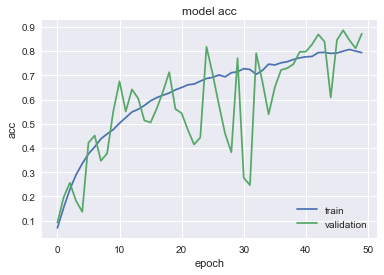

In [266]:
history, model_1m = run_nn_classifier(df_1m, hidden_layers=[542,400,300]\
                        , training_epochs=50, batch_size=10**2\
                                   , metrics_to_report=['acc'])
plot_train(history)


In [65]:
model_10m.save('model_10m.h5')
if False:
    model_10m = load_model('model_10m.h5')

get_top_n_predict(model_1m_hinge, np.array([[50,5]])/100, 5)
get_top_n_predict(model_1m_hinge, np.array([[24,45]])/100, 5)
get_top_n_predict(model_1m_hinge, np.array([[76,50]])/100, 5)
get_top_n_predict(model_1m_hinge, np.array([[4,1]])/100, 5)

NameError: name 'model_10m' is not defined